In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import unidecode
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
import re
import heapq

In [61]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16758700949335664322
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6676091371
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6490829404909022508
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Clasificación binaria de noticias Fake o True

In [2]:
#! conda install --yes nltk==3.4.5
#! conda install --yes unidecode

In [3]:
df_fake =pd.read_csv("./Fake.csv")
df_true =pd.read_csv("./True.csv")

#df_fake =pd.read_csv("Fake.csv")
#df_true =pd.read_csv("True.csv")

In [4]:
print(df_fake.shape)
df_fake.head()

(23481, 4)


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
print(df_true.shape)
df_true.head()

(21417, 4)


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [6]:
#Agregamos una columna de clase 1 para las fake
df_fake["fake"] = 1
df_fake.head()

,title,text,subject,date,fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [7]:
#Agregamos una columnas de clase 0 para las noticias True
df_true["fake"] = 0
df_true.head()

,title,text,subject,date,fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [8]:
#Concatenamos ambos datasets
df = pd.concat([df_fake, df_true], ignore_index = True)
print(df.shape)
df.head()


(44898, 5)


,title,text,subject,date,fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [9]:
df.tail()

,title,text,subject,date,fake
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",0
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",0
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",0
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",0
44897,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",0


In [10]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

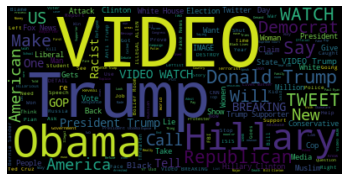

In [11]:
# Mostramos con Wordcloud una nube de palabras de Fake

text = " ".join(i for i in df_fake.title)
wordcloud = WordCloud(max_words=200).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

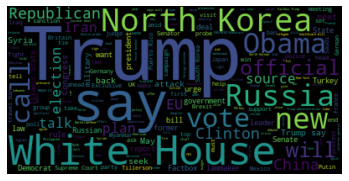

In [12]:
# Mostramos con Wordcloud una nube de palabras de True

text2 = " ".join(i for i in df_true.title)

wordcloud = WordCloud(max_words=200).generate(text2)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Analizamos los duplicados dentro del dataset

In [13]:
# Hay algunas lineas cuyos valores son exactamente identicas
df.duplicated().sum()

209

In [14]:
# Valores duplicados en titulo
df.title.duplicated(keep=False).sum()

11798

In [15]:
#Los titulos son exactamente iguales, a pesar de que la noticia es diferente
df.loc[[10920,10924],:]

,title,text,subject,date,fake
10920,MEDIA IGNORES Time That Bill Clinton FIRED His...,At the recommendation of both Attorney General...,politics,"May 10, 2017",1
10924,MEDIA IGNORES Time That Bill Clinton FIRED His...,"In its 109-year history, only one F.B.I. direc...",politics,"May 10, 2017",1


In [16]:
# El número de duplicados por título y clase coincide con el de duplicados solo por clase 
# (es decir, todos los títulos duplicados pertenecen a la misma clase)

df[["title","fake"]].duplicated(keep=False).sum()

11798

In [17]:
df[["title",'text']].duplicated(keep=False).sum()

11098

In [18]:
# Eliminamos las noticias con título duplicado, nos quedamos con los primeros
df.drop_duplicates(subset=["title","text"], keep='first', inplace=True)
df.reset_index()
df.shape

(39105, 5)

## Vemos la distribucion del dataset

In [19]:
df["fake"].value_counts(1)

0    0.542053
1    0.457947
Name: fake, dtype: float64

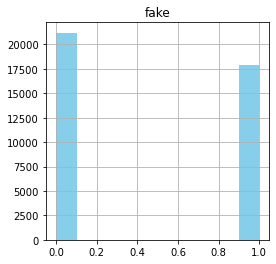

In [20]:
df.hist(figsize=(4,4), color='skyblue');

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39105 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    39105 non-null  object
 1   text     39105 non-null  object
 2   subject  39105 non-null  object
 3   date     39105 non-null  object
 4   fake     39105 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.8+ MB


In [22]:
df["subject"].value_counts(1)

politicsNews       0.286843
worldnews          0.255210
News               0.231428
politics           0.174863
US_News            0.020023
left-news          0.018028
Government News    0.013604
Name: subject, dtype: float64

C:\Users\Mariano Pesallaccia\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


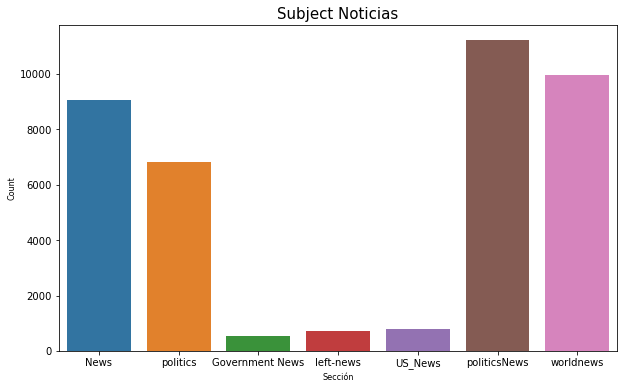

In [23]:
plt.figure(figsize=(10,6))
sns.countplot(df['subject']);

plt.title('Subject noticias'.title() , fontsize=15);
plt.ylabel('count'.title(), fontsize=8);
plt.xlabel('sección'.title(), fontsize=8);

In [24]:
#Analizamos como es la variedad de noticias según sección, considerando los True y False 
#Esto puede generar un problema de prediccion porque le va a poner 0 a todas las de la clase poiticsNews y worldnews
df.groupby(["subject", "fake"])['title'].count()

subject          fake
Government News  1         532
News             1        9050
US_News          1         783
left-news        1         705
politics         1        6838
politicsNews     0       11217
worldnews        0        9980
Name: title, dtype: int64

In [25]:
df["subject"].value_counts(1)

politicsNews       0.286843
worldnews          0.255210
News               0.231428
politics           0.174863
US_News            0.020023
left-news          0.018028
Government News    0.013604
Name: subject, dtype: float64

## Clases a unificar:
### Vemos que las clases "politics" y "politicsNews" tienen diferente nombre porque provienen de data sets diferentes 
### Como la clase "left-news" y "Goverment news" son minoritarias (< 2% cada una) las incluímos dentro de la clase "politics"

In [26]:
#unificamos categorías similares

subject_replace = {
    "politicsNews" : "politics",
    "US_News" : "News",
    "Government News" : "politics",
    "left-news" : "politics"
     }

df["new_subject"] = df["subject"]

for key in subject_replace:
    df["new_subject"] = df.new_subject.str.replace(key, subject_replace[key])
    
df.new_subject.value_counts(1)

politics     0.493338
worldnews    0.255210
News         0.251451
Name: new_subject, dtype: float64

In [27]:
df = pd.get_dummies(df, columns=['new_subject'])

In [28]:
df.drop(['subject'], axis=1, inplace=True)
df.head()#dropeamos subject porque son las categorías viejas que confundirían al modelo

,title,text,date,fake,new_subject_News,new_subject_politics,new_subject_worldnews
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,"December 31, 2017",1,1,0,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,"December 31, 2017",1,1,0,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...","December 30, 2017",1,1,0,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...","December 29, 2017",1,1,0,0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,"December 25, 2017",1,1,0,0


# Extraemos el año de la fecha

In [29]:
#Extraemos el año de date

pattern_year = r"(\d{4})"

df["year"] = df.date.str.extract(pattern_year)
df["year"].value_counts()

2017    23278
2016    14141
2015     1647
Name: year, dtype: int64

In [30]:
df.isnull().sum() #dropeamos esos 39 registros que quedaron con year nulo

title                     0
text                      0
date                      0
fake                      0
new_subject_News          0
new_subject_politics      0
new_subject_worldnews     0
year                     39
dtype: int64

In [31]:
df.dropna(subset=['year'], inplace=True)
df.isnull().sum()*100/len(df)

title                    0.0
text                     0.0
date                     0.0
fake                     0.0
new_subject_News         0.0
new_subject_politics     0.0
new_subject_worldnews    0.0
year                     0.0
dtype: float64

In [32]:
df.head()

,title,text,date,fake,new_subject_News,new_subject_politics,new_subject_worldnews,year
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,"December 31, 2017",1,1,0,0,2017
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,"December 31, 2017",1,1,0,0,2017
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...","December 30, 2017",1,1,0,0,2017
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...","December 29, 2017",1,1,0,0,2017
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,"December 25, 2017",1,1,0,0,2017


In [33]:
#Unificamos en un único campo la concatenación de los títulos y las noticias, para que sea nuestra "x"
df['news']=df['title']+ ' '+df['text'];
df.drop(['title','text'], axis=1, inplace=True)
df['news'][14000]

'WHAT THESE YOUNG ILLEGAL ‘DREAMERS’ Do To Trump Supporters Will Make Your Blood Boil [Video] What kind of monsters teach their children to behave like this? Young illegal  dreamers  and their parents flip off Trump supporters while yelling expletives you would expect to hear in a prison, and not from young boys who look to be between the ages of 8 and 12. Wearing sombreros and ironically holding signs reading  No hate,  screamed  F*ck you!  These vulgar children give us a little insight into the flagrant disrespect the illegal alien community has for the rule of law in our nation. The Mexican flags add a special touch, reminding us of where these protesters true loyalties lie.One of the most vulgar children in the center of the action could be seen wearing a Bernie Sanders sticker.Hillary Clinton campaign signs could also be seen in the crowd.One sign reads  F*ck You Puto. Puto  means  male prostitute  in Spanish.Obama s America  '

In [34]:
df.head(3)

,date,fake,new_subject_News,new_subject_politics,new_subject_worldnews,year,news
0,"December 31, 2017",1,1,0,0,2017,Donald Trump Sends Out Embarrassing New Year’...
1,"December 31, 2017",1,1,0,0,2017,Drunk Bragging Trump Staffer Started Russian ...
2,"December 30, 2017",1,1,0,0,2017,Sheriff David Clarke Becomes An Internet Joke...


# Obtenemos el mes en una columna aparte

---------------------

In [35]:
pattern_month = r"([a-zA-Z]{3})"

df["month"] = df.date.str.extract(pattern_month)
df["month"].value_counts()

Nov    5013
Oct    4932
Sep    4755
Dec    4048
Mar    2861
Jan    2697
Feb    2575
May    2566
Apr    2485
Jun    2432
Aug    2363
Jul    2337
htt       2
Name: month, dtype: int64

In [36]:
df = pd.get_dummies(df, columns=['month'])
df.drop(['date'], axis=1, inplace=True)

#### Creamos dummies de la columna mes

In [37]:
df.head()

,fake,new_subject_News,new_subject_politics,new_subject_worldnews,year,news,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,month_htt
0,1,1,0,0,2017,Donald Trump Sends Out Embarrassing New Year’...,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,2017,Drunk Bragging Trump Staffer Started Russian ...,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,2017,Sheriff David Clarke Becomes An Internet Joke...,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,2017,Trump Is So Obsessed He Even Has Obama’s Name...,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,2017,Pope Francis Just Called Out Donald Trump Dur...,0,0,1,0,0,0,0,0,0,0,0,0,0


#### Hay una columna que no tiene datos acordes al data set, por lo tanto los elimino

In [38]:
df.query('month_htt ==1')

,fake,new_subject_News,new_subject_politics,new_subject_worldnews,year,news,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,month_htt
15839,1,0,1,0,2015,https://fedup.wpengine.com/wp-content/uploads/...,0,0,0,0,0,0,0,0,0,0,0,0,1
15840,1,0,1,0,2015,https://fedup.wpengine.com/wp-content/uploads/...,0,0,0,0,0,0,0,0,0,0,0,0,1


In [39]:
df = df.drop([df.index[15839] , df.index[15840]])

In [40]:
df.drop(['month_htt'], axis=1, inplace=True)
df.head()#dropeamos subject porque son las categorías viejas que confundirían al modelo

,fake,new_subject_News,new_subject_politics,new_subject_worldnews,year,news,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
0,1,1,0,0,2017,Donald Trump Sends Out Embarrassing New Year’...,0,0,1,0,0,0,0,0,0,0,0,0
1,1,1,0,0,2017,Drunk Bragging Trump Staffer Started Russian ...,0,0,1,0,0,0,0,0,0,0,0,0
2,1,1,0,0,2017,Sheriff David Clarke Becomes An Internet Joke...,0,0,1,0,0,0,0,0,0,0,0,0
3,1,1,0,0,2017,Trump Is So Obsessed He Even Has Obama’s Name...,0,0,1,0,0,0,0,0,0,0,0,0
4,1,1,0,0,2017,Pope Francis Just Called Out Donald Trump Dur...,0,0,1,0,0,0,0,0,0,0,0,0


In [41]:
(df['news'] == 0).all() #chequeamos que no queden valores con 0 en todos los meses

False

In [42]:
df.columns

Index(['fake', 'new_subject_News', 'new_subject_politics',
       'new_subject_worldnews', 'year', 'news', 'month_Apr', 'month_Aug',
       'month_Dec', 'month_Feb', 'month_Jan', 'month_Jul', 'month_Jun',
       'month_Mar', 'month_May', 'month_Nov', 'month_Oct', 'month_Sep'],
      dtype='object')

In [43]:
df.dtypes

fake                      int64
new_subject_News          uint8
new_subject_politics      uint8
new_subject_worldnews     uint8
year                     object
news                     object
month_Apr                 uint8
month_Aug                 uint8
month_Dec                 uint8
month_Feb                 uint8
month_Jan                 uint8
month_Jul                 uint8
month_Jun                 uint8
month_Mar                 uint8
month_May                 uint8
month_Nov                 uint8
month_Oct                 uint8
month_Sep                 uint8
dtype: object

# Hacer bolsa de palabras

https://stackabuse.com/python-for-nlp-creating-bag-of-words-model-from-scratch/

In [44]:
def clean_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'\W',' ',sentence)
    sentence = re.sub(r'\s+',' ',sentence)
    return sentence.split(' ')

In [45]:
df['news'] = df['news'].apply(lambda x: clean_sentence(x))

In [46]:
df.head()

,fake,new_subject_News,new_subject_politics,new_subject_worldnews,year,news,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
0,1,1,0,0,2017,"[, donald, trump, sends, out, embarrassing, ne...",0,0,1,0,0,0,0,0,0,0,0,0
1,1,1,0,0,2017,"[, drunk, bragging, trump, staffer, started, r...",0,0,1,0,0,0,0,0,0,0,0,0
2,1,1,0,0,2017,"[, sheriff, david, clarke, becomes, an, intern...",0,0,1,0,0,0,0,0,0,0,0,0
3,1,1,0,0,2017,"[, trump, is, so, obsessed, he, even, has, oba...",0,0,1,0,0,0,0,0,0,0,0,0
4,1,1,0,0,2017,"[, pope, francis, just, called, out, donald, t...",0,0,1,0,0,0,0,0,0,0,0,0


In [47]:
news_words=df['news'].copy()

In [48]:
frequency={}
for sentence in news_words:
    for word in sentence:
        if word in frequency.keys():
            frequency[word]+=1
        else:
            frequency[word]=1

In [49]:
len(frequency.keys())

122411

In [50]:
frecuency_values=np.array(list(frequency.values()))
stats.describe(frecuency_values)

DescribeResult(nobs=122411, minmax=(1, 876447), mean=134.82362696162926, variance=15756705.8966433, skewness=132.17137609564483, kurtosis=23465.645096291966)

In [54]:
most_freq = heapq.nlargest(50000, frequency, key=frequency.get)

In [55]:
most_freq[1]

'to'

In [62]:
sentence_vectors = []
for sentence in tqdm(news_words):
    sent_vec = []
    for word in most_freq:
        if word in sentence:
            sent_vec.append(1)
        else:
            sent_vec.append(0)
    sentence_vectors.append(sent_vec)

  3%|▎         | 992/39064 [03:43<2:23:08,  4.43it/s]


KeyboardInterrupt: 

In [1]:
sentence_vectors = np.asarray(sentence_vectors).astype(np.int8)

NameError: name 'np' is not defined

In [ ]:
words_df = pd.DataFrame(sentence_vectors, columns=range(50000))

In [ ]:
words_df.shape

In [ ]:
df.shape

In [ ]:
df.reset_index()
words_df.reset_index()

In [ ]:
words_df.dtypes

In [ ]:
df_full = pd.merge(df,words_df,left_index=True, right_index=True)

In [ ]:
df_full.shape

In [ ]:
df_full.drop(['news'], axis=1, inplace=True)

In [ ]:
df_full['year']=pd.to_numeric(df_full["year"], downcast='integer')

In [ ]:
X=df_full.copy()
X.drop(['fake'], axis=1, inplace=True)

In [ ]:
y=df_full['fake']

## Separamos en train test y validacion

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))
display(x_train.shape, x_val.shape, x_test.shape,  y_test.shape, y_val.shape, y_train.shape)


In [ ]:
model = Sequential()
model.add(Dense(15, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(10, activation='sigmoid', input_shape=(x_train.shape[1],)))
model.add(Dense(1, activation='sigmoid'))
model.summary()

In [ ]:
# Compilamos el modelo
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Instanciamos nuestro objeto early_stopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

# Instanciamos nuestro objeto chekpoint
checkpoint = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0,
                             save_best_only=True, save_weights_only=False, mode='auto')
callbacks_list = [reduce_lr,early_stopping]

In [ ]:
# Entrenamos
history = model.fit(x=x_train, y=y_train,
                    epochs=100, batch_size=512, validation_data=(x_val, y_val),callbacks=callbacks_list)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(12,8))
plt.title('Modelo más grande')
plt.xticks(ticks=epochs)
plt.ylabel('Loss')
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(['Training loss', 'Validation loss'])

plt.figure(figsize=(12,8))
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.xticks(ticks=list(epochs))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy']);

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100 , "%")